In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt","r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
        

In [28]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
        

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [45]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [101]:
g = torch.Generator().manual_seed(2147843647)
C = torch.randn((27, 10), generator = g)
W1 = torch.randn((30, 300), generator = g)
b1 = torch.randn(300, generator = g)
W2 = torch.randn((300, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [102]:
sum(p.nelement() for p in parameters)

17697

In [103]:
for p in parameters:
    p.requires_grad = True

In [104]:
#Exponentiating Lrs
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [105]:
lri = []
lossi = []
stepi = []

In [106]:
for i in range(200000):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    #Forward Pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    #Backward pass
    #lr = lrs[i]
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #Track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

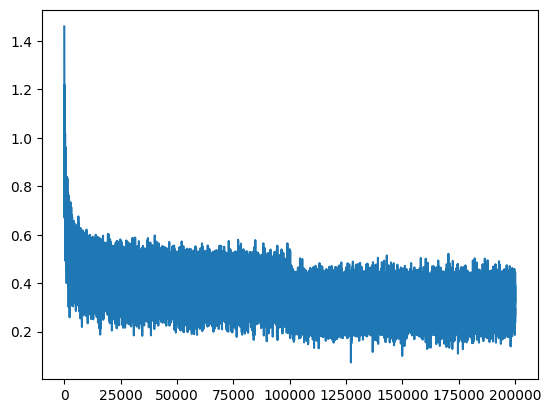

In [107]:
plt.plot(stepi, lossi)

In [108]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1122, grad_fn=<NllLossBackward0>)

In [109]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1720, grad_fn=<NllLossBackward0>)

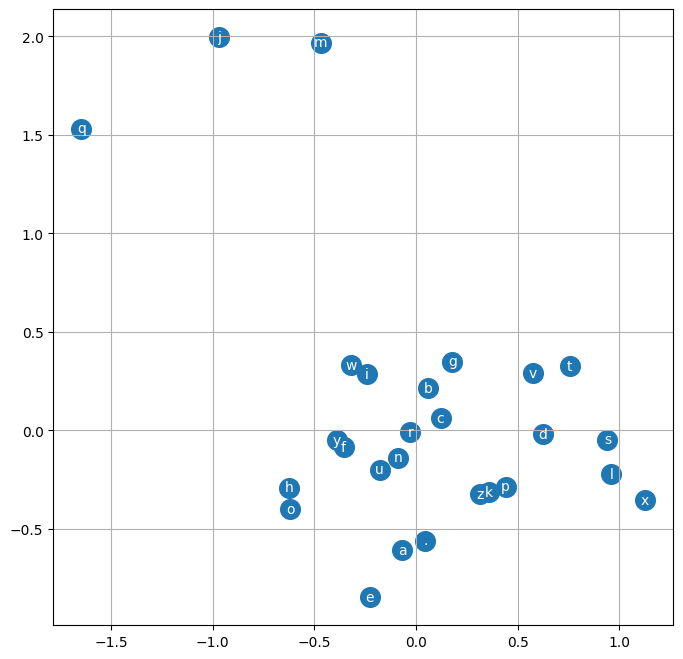

In [110]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range (C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [ ]:
# Training split, dev/validation split, test split
# 80%, 10%, 10%